In [22]:
# =========================
# Import Libraries
# =========================
import pandas as pd
import networkx as nx

import tqdm as tqdm

import numpy as np
from matplotlib import pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from scipy.stats import spearmanr
from sklearn.metrics import auc
from sklearn.decomposition import PCA

In [23]:
# =========================
# Helper Functions
# =========================


def tune_isolation_forest(
    X: pd.DataFrame,
    contaminations: float = np.linspace(0.01, 0.2, 10),
    estimators: int = np.linspace(50, 200, 4),
    n_runs: int = 10,
) -> tuple:
    """
    Tune Isolation Forest hyperparameters based on stability heuristic.
    :param X: Training data
    :param contaminations: Appropriate contamination levels to try
    :param estimators: Amount of trees in the forest
    :param n_runs: Number of runs to estimate stability
    :return: Optimal parameters for Isolation Forest on the given data.
    """
    best_score = -np.inf
    best_params = None
    for estimator in estimators:
        for cont in contaminations:
            scores = []
            for _ in range(n_runs):
                iso = IsolationForest(
                    n_estimators=int(estimator),
                    max_samples="auto",
                    contamination=cont,
                    random_state=None,
                )
                scores.append(iso.fit(X).score_samples(X))

            corr = []
            for i in range(len(scores) - 1):
                corr.append(spearmanr(scores[i], scores[i + 1])[0])

            stability = np.nanmean(corr)

            if stability > best_score:
                best_score = stability
                best_params = (int(estimator), cont)

        return best_params


def tune_lof(X: pd.DataFrame) -> int:
    """
    Tune Local Outlier Factor hyperparameters based on separation heuristic.
    :param X: Validation data
    :return: Optimal number of neighbors for LOF on the given data.
    """
    n = len(X)
    candidates = [int(np.sqrt(n)), int(1.5 * np.sqrt(n)), int(2 * np.sqrt(n))]
    candidates = [k for k in candidates if k < n]

    best_k = None
    best_sep = -np.inf

    for k in candidates:
        lof = LocalOutlierFactor(n_neighbors=k)
        scores = -lof.fit_predict(X)

        # Separation heuristic: std of LOF scores
        sep = np.std(lof.negative_outlier_factor_)

        if sep > best_sep:
            best_sep = sep
            best_k = k

    return best_k


def calculate_model_stability(anomaly_scores_list: list) -> float:
    """
    Calculate the stability of a model based on Spearman correlation.
    :param anomaly_scores_list: List of anomaly scores from different runs of the same model
    :return: Spearman correlation-based stability score
    """
    correlation_scores = []
    for i in range(len(anomaly_scores_list) - 1):
        correlation, _ = spearmanr(anomaly_scores_list[i], anomaly_scores_list[i + 1])
        correlation_scores.append(correlation)
    stability_score = np.nanmean(correlation_scores)
    return stability_score


def calculate_model_agreement(model1_labels: list, model2_labels: list) -> float:
    """
    Calculate agreement between two sets of anomaly labels.
    :param model1_labels: Labels from model 1
    :param model2_labels: Labels from model 2
    :return: Agreement score
    """
    agreement_score = np.mean(model1_labels == model2_labels)
    return agreement_score


def em(
    t_values: np.ndarray,
    t_max_threshold: float,
    support_volume: float,
    uniform_scores: np.ndarray,
    test_scores: np.ndarray,
    num_generated_samples: int,
) -> tuple:
    """
    Compute Excess-Mass (EM) curve and its AUC.

    :param t_values: Array of t values.
    :param t_max_threshold: Maximum t threshold.
    :param support_volume: Volume of the support.
    :param uniform_scores: Scores of the uniform samples.
    :param test_scores: Scores of the test samples.
    :param num_generated_samples: Number of generated uniform samples.
    :return: Tuple containing EM AUC, EM values, and the index of the maximum t value.
    """
    em_values = np.zeros(t_values.shape[0])
    num_test_samples = test_scores.shape[0]
    unique_test_scores = np.unique(test_scores)
    em_values[0] = 1.0

    for score in unique_test_scores:
        em_values = np.maximum(
            em_values,
            1.0 / num_test_samples * (test_scores > score).sum()
            - t_values
            * (uniform_scores > score).sum()
            / num_generated_samples
            * support_volume,
        )

    max_t_index = np.argmax(em_values <= t_max_threshold) + 1
    if max_t_index == 1:
        print("\nFailed to achieve t_max_threshold\n")
        max_t_index = -1

    em_auc = auc(t_values[:max_t_index], em_values[:max_t_index])
    return em_auc, em_values, max_t_index


def mv(
    alpha_values: np.ndarray,
    support_volume: float,
    uniform_scores: np.ndarray,
    test_scores: np.ndarray,
    num_generated_samples: int,
) -> tuple:
    """
    Compute Mass-Volume (MV) curve and its AUC.

    :param alpha_values: Array of alpha values.
    :param support_volume: Volume of the support.
    :param uniform_scores: Scores of the uniform samples.
    :param test_scores: Scores of the test samples.
    :param num_generated_samples: Number of generated uniform samples.
    :return: Tuple containing MV AUC and MV values.
    """
    num_test_samples = test_scores.shape[0]
    sorted_test_scores_indices = test_scores.argsort()
    cumulative_mass = 0
    count = 0
    threshold_score = test_scores[sorted_test_scores_indices[-1]]
    mv_values = np.zeros(alpha_values.shape[0])

    for i in range(alpha_values.shape[0]):
        while cumulative_mass < alpha_values[i]:
            count += 1
            threshold_score = test_scores[sorted_test_scores_indices[-count]]
            cumulative_mass = 1.0 / num_test_samples * count
        mv_values[i] = (
            float((uniform_scores >= threshold_score).sum())
            / num_generated_samples
            * support_volume
        )

    mv_auc = auc(alpha_values, mv_values)
    return mv_auc, mv_values


def plot_country_anomalies(country_name: str):
    """
    Plot time series of weighted in/out degrees and degrees for a given country,
    and scatterplot of PCA-reduced features.

    :param country_name: Name of the country to plot.
    :return: Saves the plots to disk.
    """
    country_data = (
        feature_engineered_arms_trade_df[
            feature_engineered_arms_trade_df["country"] == country_name
        ]
        .sort_values("year")
        .set_index("year")
    )

    # Create a full year range to expose missing years
    full_years = np.arange(country_data.index.min(), country_data.index.max() + 1)
    country_data_full = country_data.reindex(full_years)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

    # Plot weighted volumes (TIV)
    ax1.plot(
        country_data_full.index,
        country_data_full["weighted_out_degree"],
        color="blue",
        linewidth=2,
        label="Exports",
    )
    ax1.plot(
        country_data_full.index,
        country_data_full["weighted_in_degree"],
        color="green",
        linewidth=2,
        label="Imports",
    )

    # Handle missing years with dotted lines
    for column_name, color in [
        ("weighted_out_degree", "blue"),
        ("weighted_in_degree", "green"),
    ]:
        column_values = country_data_full[column_name]
        valid_indices = np.where(~np.isnan(column_values.values))[0]
        for i in range(len(valid_indices) - 1):
            start_idx, end_idx = valid_indices[i], valid_indices[i + 1]
            if end_idx - start_idx > 1:
                ax1.plot(
                    [column_values.index[start_idx], column_values.index[end_idx]],
                    [column_values.iloc[start_idx], column_values.iloc[end_idx]],
                    color=color,
                    linestyle=":",
                    linewidth=2,
                    alpha=0.8,
                )

    # Highlight anomalies
    iso_anomaly_years = country_data_full.index[
        country_data_full["iso_anomaly"] & ~country_data_full["lof_anomaly"]
    ]
    lof_anomaly_years = country_data_full.index[
        country_data_full["lof_anomaly"] & ~country_data_full["iso_anomaly"]
    ]
    joint_anomaly_years = country_data_full.index[
        country_data_full["iso_anomaly"] & country_data_full["lof_anomaly"]
    ]

    for year in iso_anomaly_years:
        ax1.axvline(
            x=year,
            color="cyan",
            linestyle="--",
            alpha=0.8,
            label="IF only" if year == iso_anomaly_years[0] else "",
        )
    for year in lof_anomaly_years:
        ax1.axvline(
            x=year,
            color="magenta",
            linestyle="--",
            alpha=0.8,
            label="LOF only" if year == lof_anomaly_years[0] else "",
        )
    for year in joint_anomaly_years:
        ax1.axvline(
            x=year,
            color="red",
            linestyle="-",
            linewidth=2,
            alpha=0.8,
            label="Overlap" if year == joint_anomaly_years[0] else "",
        )

    ax1.set_ylabel("Weighted Arms Transfers (TIV)")
    ax1.set_title(f"{country_name} Arms Transfers: Volume")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Plot network connectivity (degrees)
    ax2.plot(
        country_data_full.index,
        country_data_full["out_degree"],
        color="blue",
        linewidth=2,
        label="Out Degree",
    )
    ax2.plot(
        country_data_full.index,
        country_data_full["in_degree"],
        color="green",
        linewidth=2,
        label="In Degree",
    )

    for column_name, color in [("out_degree", "blue"), ("in_degree", "green")]:
        column_values = country_data_full[column_name]
        valid_indices = np.where(~np.isnan(column_values.values))[0]
        for i in range(len(valid_indices) - 1):
            start_idx, end_idx = valid_indices[i], valid_indices[i + 1]
            if end_idx - start_idx > 1:
                ax2.plot(
                    [column_values.index[start_idx], column_values.index[end_idx]],
                    [column_values.iloc[start_idx], column_values.iloc[end_idx]],
                    color=color,
                    linestyle=":",
                    linewidth=2,
                    alpha=0.8,
                )

    # Highlight anomalies for connectivity
    for year in iso_anomaly_years:
        ax2.axvline(x=year, color="cyan", linestyle="--", alpha=0.8)
    for year in lof_anomaly_years:
        ax2.axvline(x=year, color="magenta", linestyle="--", alpha=0.8)
    for year in joint_anomaly_years:
        ax2.axvline(x=year, color="red", linestyle="-", linewidth=2, alpha=0.8)

    ax2.set_ylabel("Number of Trade Partners (Degree)")
    ax2.set_xlabel("Year")
    ax2.set_title(f"{country_name} Arms Transfers: Network Connectivity")
    ax2.grid(True, linestyle="--", alpha=0.6)

    # Add legend
    fig.legend(loc="upper center", ncol=4, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"results/{country_name}_lineplot_anomalies.png")
    plt.show()


def plot_pca_with_anomalies_combined(
    country_name: str,
    feature_columns: list = [
        "year_scaled",
        "in_degree",
        "out_degree",
        "weighted_in_degree",
        "weighted_out_degree",
    ],
    plot_title: str = "PCA Scatter Plot with Anomalies",
):
    """
    Apply PCA to reduce the dataset to 2 dimensions and plot a single scatter plot
    with both Isolation Forest and LOF anomalies.

    :param country_name: Name of the country to plot.
    :param feature_columns: List of feature columns to use for PCA.
    :param plot_title: Title of the plot.
    :return: Saves the plot to disk.
    """

    country_data = (
        feature_engineered_arms_trade_df[
            feature_engineered_arms_trade_df["country"] == country_name
        ]
        .sort_values("year")
        .set_index("year")
    )

    # Extract features and anomalies
    features = country_data[feature_columns].dropna()
    iso_anomaly_points = country_data.loc[features.index, "iso_anomaly"]
    lof_anomaly_points = country_data.loc[features.index, "lof_anomaly"]

    overlap_anomaly_points = iso_anomaly_points & lof_anomaly_points
    iso_only_anomaly_points = iso_anomaly_points & ~lof_anomaly_points
    lof_only_anomaly_points = lof_anomaly_points & ~iso_anomaly_points
    normal_data_points = ~(iso_anomaly_points | lof_anomaly_points)

    pca = PCA(n_components=5)
    pca_transformed_features = pca.fit_transform(features)

    plt.figure(figsize=(10, 8))
    plt.scatter(
        pca_transformed_features[normal_data_points, 0],
        pca_transformed_features[normal_data_points, 1],
        c="blue",
        label="Normal",
        alpha=0.6,
    )
    plt.scatter(
        pca_transformed_features[iso_only_anomaly_points, 0],
        pca_transformed_features[iso_only_anomaly_points, 1],
        c="cyan",
        label="IF only",
        alpha=0.8,
    )
    plt.scatter(
        pca_transformed_features[lof_only_anomaly_points, 0],
        pca_transformed_features[lof_only_anomaly_points, 1],
        c="magenta",
        label="LOF only",
        alpha=0.8,
    )
    plt.scatter(
        pca_transformed_features[overlap_anomaly_points, 0],
        pca_transformed_features[overlap_anomaly_points, 1],
        c="red",
        label="Overlap",
        alpha=0.8,
    )

    plt.title(plot_title, fontsize=16)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(f"results/{country_name}_scatterplot_anomalies.png")
    plt.show()


def plot_datapoints_per_year(df: pd.DataFrame, year_left: int, year_right: int):
    """
    Plot number of data points per year with vertical lines indicating feasible bandwidth.
    :param df: DataFrame with years as index and counts as values.
    :param year_left: Minimum year of feasible bandwidth.
    :param year_right: Maximum year of feasible bandwidth.
    :return: Plot saved to disk.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df.values, marker="o", linestyle="-", color="blue")
    plt.title("Selected Feasible Bandwidth Based on Data Stability")
    plt.xlabel("Year")
    plt.ylabel("Number of Data Points")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.axvline(x=year_left, color="red", linestyle=":", linewidth=2, alpha=0.8)
    plt.axvline(x=year_right, color="red", linestyle=":", linewidth=2, alpha=0.8)
    plt.tight_layout()
    plt.savefig("results/data_points_per_year.png", format="png", dpi=300)
    plt.show()

In [24]:
# =========================
# Load SIPRI Data and Preprocess
# =========================

# CSV must have columns: year, exporter, importer, tiv
arms_trade_dataframe = pd.read_csv("data/trade-register.csv")

arms_trade_dataframe.info()

# Selecting relevant columns

arms_trade_dataframe = arms_trade_dataframe[
    ["Year of order", "Supplier", "Recipient", "SIPRI TIV for total order"]
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Recipient                       14284 non-null  object 
 1   Supplier                        14286 non-null  object 
 2   Year of order                   14286 non-null  float64
 3                                   5899 non-null   object 
 4   Number ordered                  14176 non-null  float64
 5    .1                             5847 non-null   object 
 6   Weapon designation              14284 non-null  object 
 7   Weapon description              14284 non-null  object 
 8   Number delivered                14284 non-null  float64
 9    .2                             8124 non-null   object 
 10  Year(s) of delivery             14284 non-null  object 
 11  status                          14284 non-null  object 
 12  Comments                        

In [25]:
# Removing rows with missing values
print(arms_trade_dataframe.isna().sum())
arms_trade_dataframe = arms_trade_dataframe.dropna()
print(arms_trade_dataframe.isna().sum())

Year of order                0
Supplier                     0
Recipient                    2
SIPRI TIV for total order    4
dtype: int64
Year of order                0
Supplier                     0
Recipient                    0
SIPRI TIV for total order    0
dtype: int64


In [26]:
# Check for negative TIV values and remove them
arms_trade_dataframe = arms_trade_dataframe[
    arms_trade_dataframe["SIPRI TIV for total order"] >= 0
]

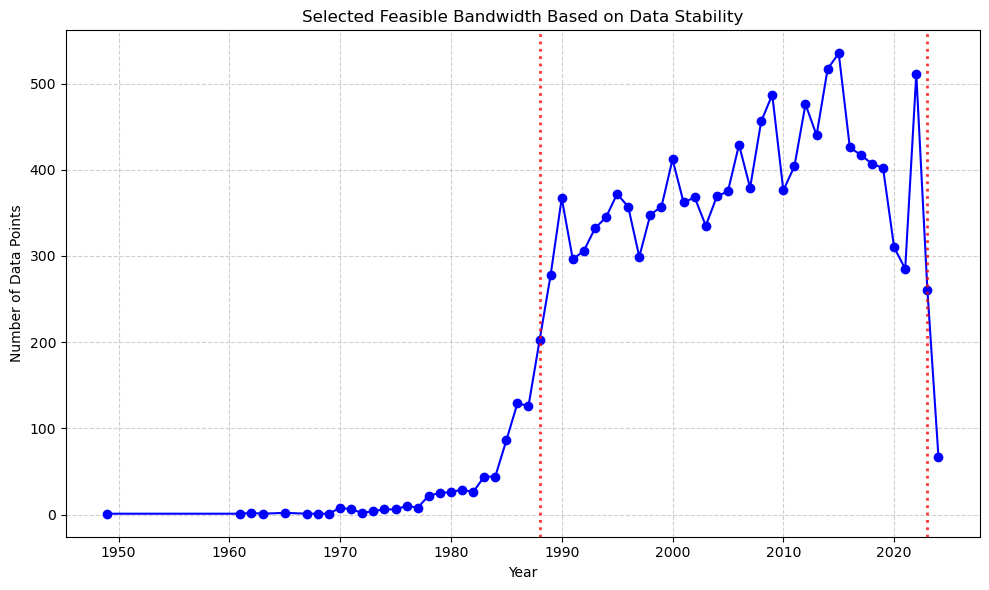

In [27]:
# ========================================================================
#  Determine Feasible Bandwidth Based on Data Precision and trim dataframe
# ========================================================================

counts = (
    arms_trade_dataframe.groupby("Year of order")
    .size()
    .reset_index(name="n_obs")
    .sort_values("Year of order")
)
counts["se_proxy"] = 1 / np.sqrt(counts["n_obs"])
counts["relative_se"] = counts["se_proxy"] / counts["se_proxy"].min()

precision_threshold = 2.0

counts["precise_enough"] = counts["relative_se"] <= precision_threshold

precision_year_left = counts.loc[counts["precise_enough"], "Year of order"].min()
precision_year_right = counts.loc[counts["precise_enough"], "Year of order"].max()

data_points_per_year = arms_trade_dataframe.groupby("Year of order").size()
plot_datapoints_per_year(
    data_points_per_year, precision_year_left, precision_year_right
)

# reset dataframe to feasible bandwidth
arms_trade_dataframe_trimmed = arms_trade_dataframe[
    (arms_trade_dataframe["Year of order"] >= precision_year_left)
    & (arms_trade_dataframe["Year of order"] <= precision_year_right)
]

In [28]:
# =========================
#  Create Yearly Graphs
# =========================
graphs_by_year = {}
for year, year_df in arms_trade_dataframe_trimmed.groupby("Year of order"):
    G = nx.DiGraph(year=year)
    for _, row in year_df.iterrows():
        exporter = row["Supplier"]
        importer = row["Recipient"]
        tiv = row["SIPRI TIV for total order"]
        if G.has_edge(exporter, importer):
            G[exporter][importer]["weight"] += tiv
        else:
            G.add_edge(exporter, importer, weight=tiv)
    graphs_by_year[year] = G

# =========================
# Compute Node Features
# =========================
all_features = []
for year, G in graphs_by_year.items():
    for node in G.nodes:
        all_features.append(
            {
                "year": year,
                "country": node,
                "in_degree": G.in_degree(node),
                "out_degree": G.out_degree(node),
                "weighted_in_degree": G.in_degree(node, weight="weight"),
                "weighted_out_degree": G.out_degree(node, weight="weight"),
            }
        )

feature_engineered_arms_trade_df = pd.DataFrame(all_features)

In [29]:
# ===============================
# Build full country–year grid
# ===============================

feature_engineered_arms_trade_df = (
    feature_engineered_arms_trade_df.set_index(["year", "country"])
    .reindex(
        pd.MultiIndex.from_product(
            [
                feature_engineered_arms_trade_df["year"].unique(),
                feature_engineered_arms_trade_df["country"].unique(),
            ],
            names=["year", "country"],
        )
    )
    .reset_index()
)

# ================================================================
# Rescale years linearly for extra feature in anomaly detection
# ================================================================

feature_engineered_arms_trade_df["year_scaled"] = MinMaxScaler().fit_transform(
    feature_engineered_arms_trade_df[["year"]]
)

In [30]:
feature_cols = [
    "year_scaled",
    "in_degree",
    "out_degree",
    "weighted_in_degree",
    "weighted_out_degree",
]


# Determine minimum data points required per country based on feasible bandwidth, 80% selected
minimum_data_points = np.round((precision_year_right - precision_year_left) * 0.8, 0)
print(f"Minimum data points per country: {minimum_data_points}")

Minimum data points per country: 28.0


In [31]:
# ===============================================================================================================================
# Train and fit IsolationForest, LocalOutlierFactor, and combine them per country. Evaluate Country Performace and store in DF
# ==============================================================================================================================

evaluation_rows = []

feature_engineered_arms_trade_df["iso_anomaly"] = False
feature_engineered_arms_trade_df["lof_anomaly"] = False
feature_engineered_arms_trade_df["combined_anomaly"] = False

for country, df_c in tqdm.tqdm(
    feature_engineered_arms_trade_df.groupby("country"), desc="Processing countries"
):
    df_c = df_c.sort_values("year_scaled").dropna()

    if len(df_c) < minimum_data_points:
        continue

    X = df_c[feature_cols].values

    # Hyperparameter tuning
    best_param_iso = tune_isolation_forest(X)
    best_k = tune_lof(X)

    # Fit Isolation Forest
    iso = IsolationForest(
        n_estimators=best_param_iso[0], contamination=best_param_iso[1], random_state=42
    )
    iso_scores = iso.fit(X).decision_function(X)
    iso_labels = iso_scores < np.percentile(iso_scores, 100 * best_param_iso[1])

    # Fit LOF
    lof = LocalOutlierFactor(n_neighbors=best_k)
    lof_labels = lof.fit_predict(X) == -1
    lof_scores = -lof.negative_outlier_factor_

    # Combine LOF and IF
    combined_scores = (iso_scores + lof_scores) / 2  # Average of scores
    combined_labels = combined_scores < np.percentile(
        combined_scores, 100 * best_param_iso[1]
    )

    # Update features_df with anomaly labels
    feature_engineered_arms_trade_df.loc[df_c.index, "iso_anomaly"] = iso_labels
    feature_engineered_arms_trade_df.loc[df_c.index, "lof_anomaly"] = lof_labels
    feature_engineered_arms_trade_df.loc[df_c.index, "combined_anomaly"] = (
        combined_labels
    )

    iso_stability = calculate_model_stability(
        [iso_scores for _ in range(10)]
    )  # Example: 10 runs
    lof_stability = calculate_model_stability(
        [lof_scores for _ in range(10)]
    )  # Example: 10 runs

    # Model Agreement
    model_agreement = calculate_model_agreement(iso_labels, lof_labels)

    # Append evaluation results
    evaluation_rows.append(
        {
            "country": country,
            "iso_stability": calculate_model_stability([iso_scores for _ in range(10)]),
            "lof_stability": calculate_model_stability([lof_scores for _ in range(10)]),
            "model_agreement": calculate_model_agreement(iso_labels, lof_labels),
        }
    )

# Convert evaluation results to DataFrame
evaluation_df = pd.DataFrame(evaluation_rows)

Processing countries: 100%|██████████| 221/221 [02:22<00:00,  1.55it/s]


In [32]:
evaluation_df.describe()

,iso_stability,lof_stability,model_agreement
count,6.500000e+01,6.500000e+01,65.000000
mean,1.000000e+00,1.000000e+00,0.790207
std,8.326673e-17,1.000742e-16,0.101837
min,1.000000e+00,1.000000e+00,0.464286
25%,1.000000e+00,1.000000e+00,0.733333
50%,1.000000e+00,1.000000e+00,0.794118
75%,1.000000e+00,1.000000e+00,0.861111
max,1.000000e+00,1.000000e+00,0.972222


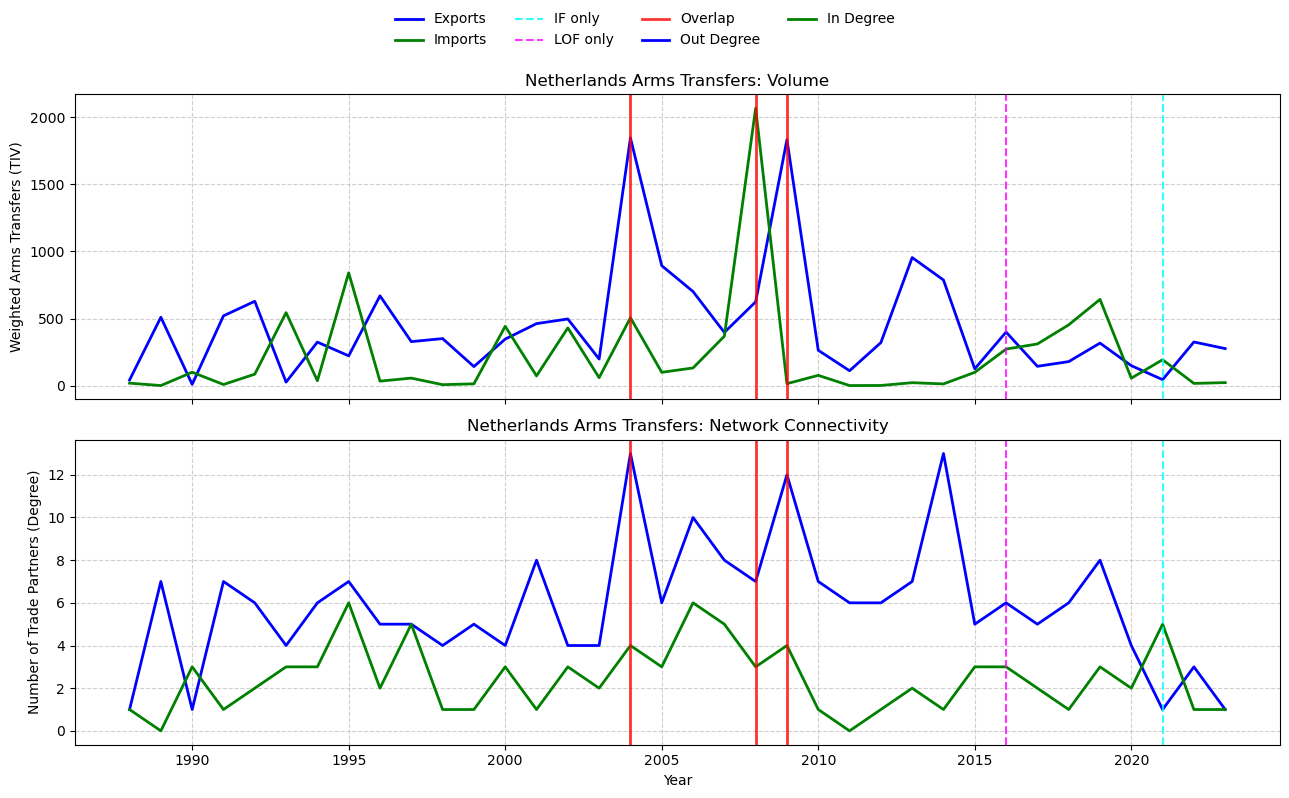

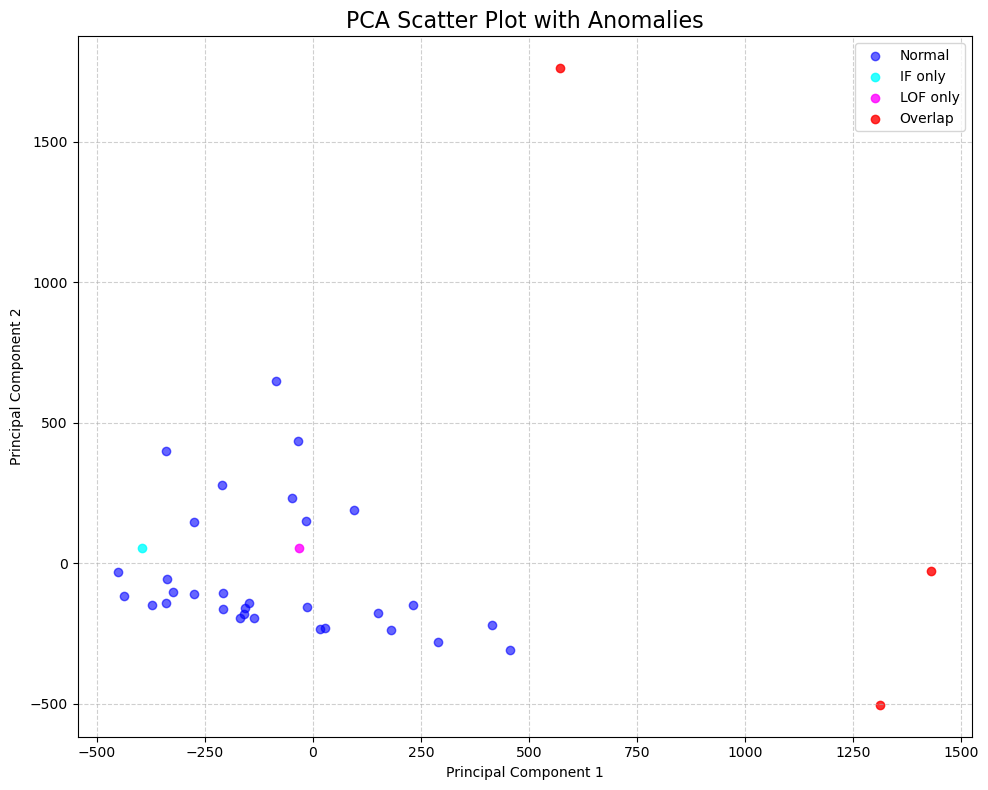

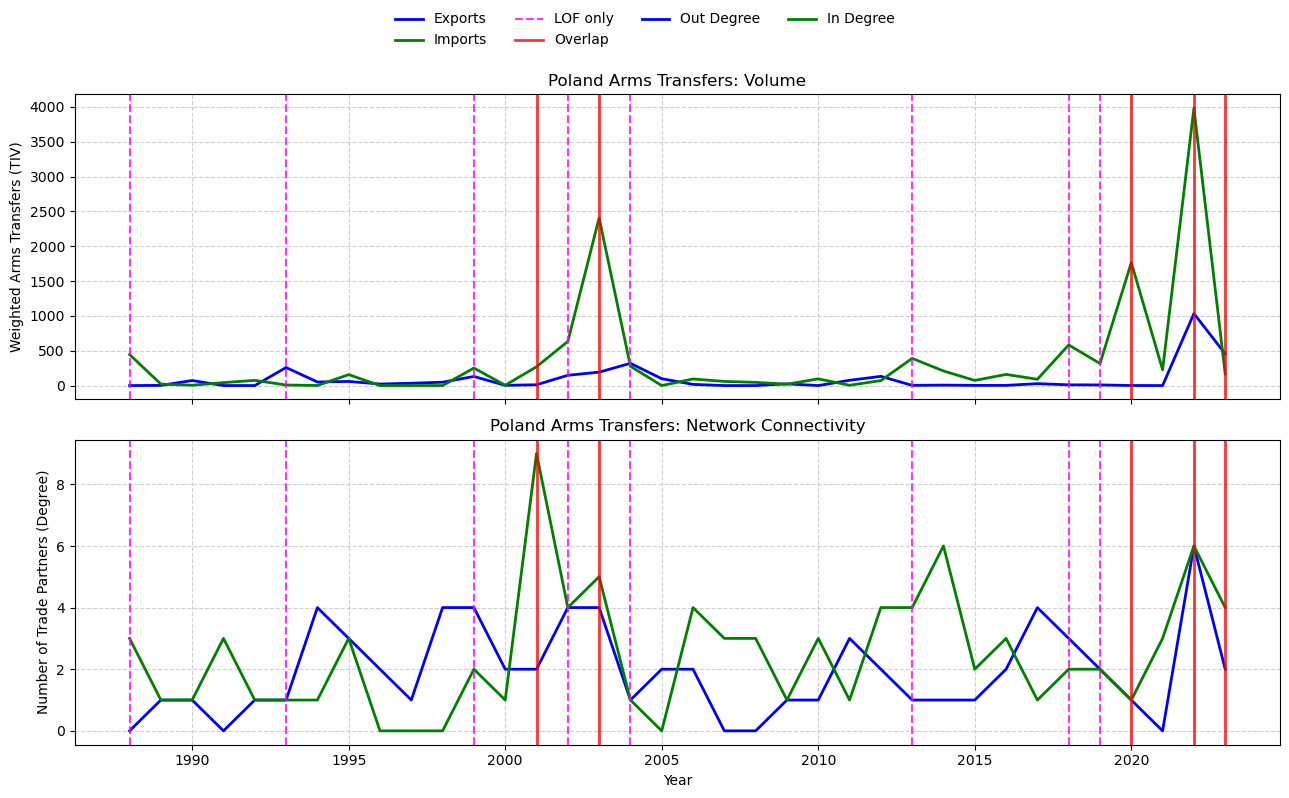

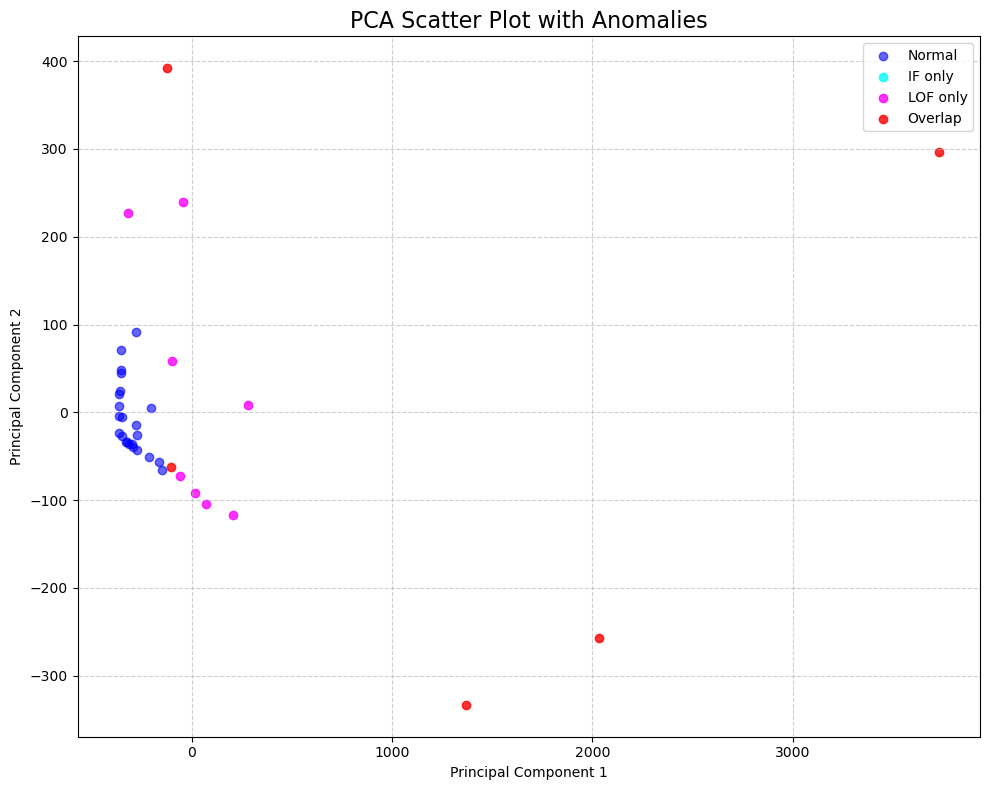

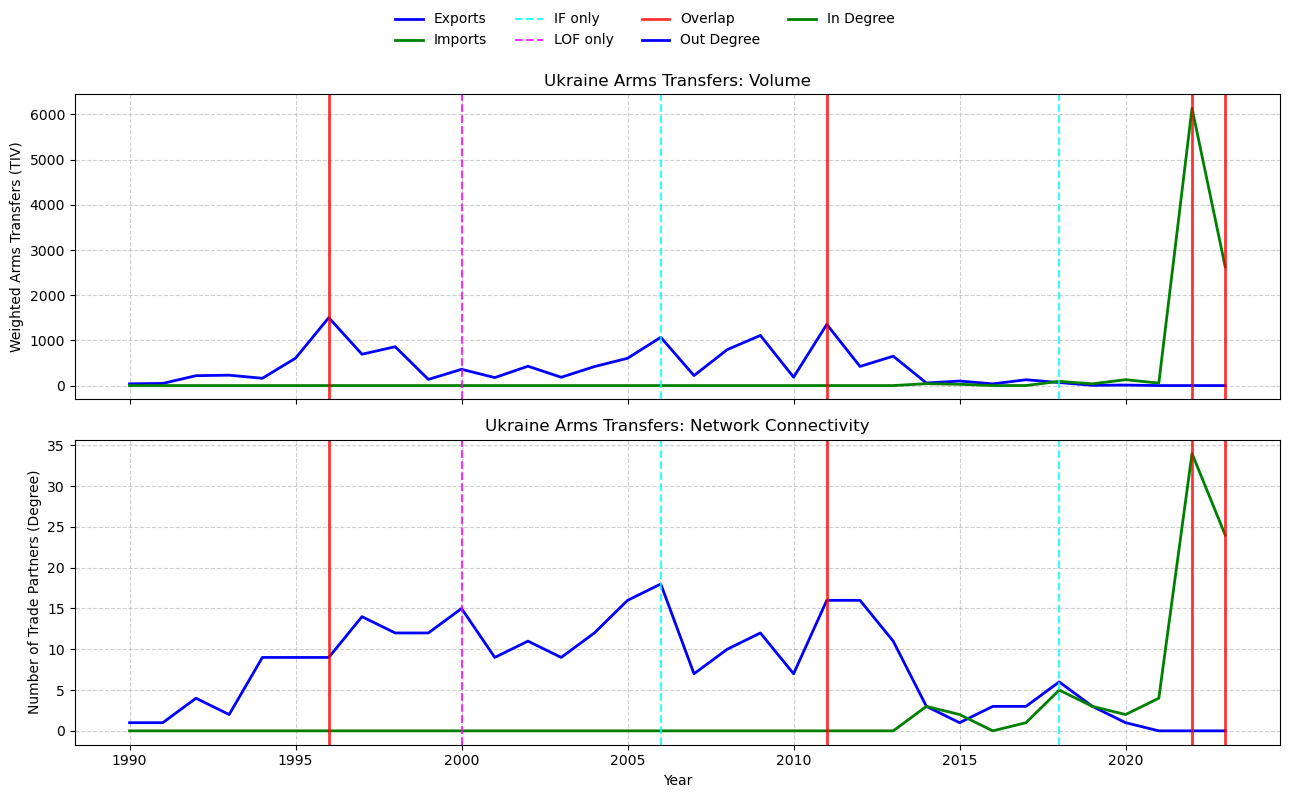

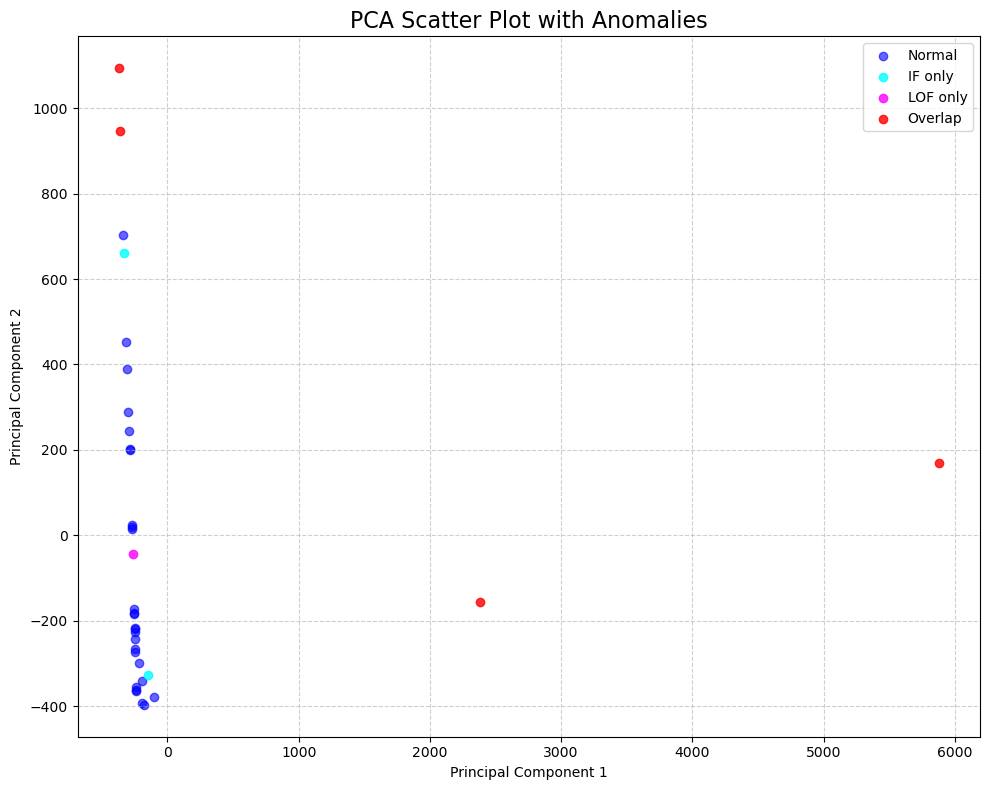

In [35]:
countries = ["Netherlands", "Poland", "Ukraine"]

for country in countries:
    plot_country_anomalies(country)
    plot_pca_with_anomalies_combined(country)

In [ ]:
# Based On https://github.com/ngoix/EMMV_benchmarks/blob/master/em.py

# Parameters of the algorithm and data

n_generated = 100000  # Number of generated uniform samples
alpha_min = 0.9  # Minimum alpha value for MV curve
alpha_max = 0.999  # Maximum alpha value for MV curve
t_max = 0.9  # Maximum t threshold for EM curve


# Set random seed for reproducibility
np.random.seed(42)

# Initialize figure for plotting
plt.figure(figsize=(25, 13))

# Load and vectorize the feature data
X = feature_engineered_arms_trade_df[feature_cols].dropna().values

# Split data into training and testing sets
n_samples, n_features = np.shape(X)
n_samples_train = n_samples // 2
n_samples_test = n_samples - n_samples_train

X_train = X[:n_samples_train, :]  # Training data
X_test = X[n_samples_train:, :]  # Testing data

# Tune hyperparameters for Isolation Forest and LOF
best_param_iso = tune_isolation_forest(X)
best_k = tune_lof(X)

# ---------------------------
# Fit Isolation Forest
# ---------------------------
iforest = IsolationForest(
    n_estimators=best_param_iso[0],  # Best number of estimators
    contamination=best_param_iso[1],  # Best contamination level
)

# Fit Local Outlier Factor with the best number of neighbors
lof = LocalOutlierFactor(n_neighbors=best_k, novelty=True)

# Calculate the limits of the feature space
lim_inf = X.min(axis=0)  # Minimum values for each feature
lim_sup = X.max(axis=0)  # Maximum values for each feature

# Calculate the volume of the support (bounding box of the feature space)
volume_support = (lim_sup - lim_inf).prod()

# Check if the volume is valid
if volume_support <= 0:
    raise ValueError("volume_support is zero or negative. Check your input data.")

# Generate t values and alpha values for EM and MV curves
step_size = max(0.01 / volume_support, 1e-10)  # Ensure step size is not too small
t = np.arange(0, 100 / volume_support, step_size)  # t values for EM curve
axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)  # Alpha values for MV curve

# Generate uniform samples within the feature space
unif = np.random.uniform(lim_inf, lim_sup, size=(n_generated, n_features))

# Fit Isolation Forest and calculate decision scores
print("IsolationForest processing...")
iforest.fit(X_train)
s_X_iforest = iforest.decision_function(X_test)  # Scores for test data
s_unif_iforest = iforest.decision_function(unif)  # Scores for uniform samples

# Fit Local Outlier Factor and calculate decision scores
print("LocalOutlierFactor processing...")
lof.fit(X_train)
s_X_lof = lof.decision_function(X_test)  # Scores for test data
s_unif_lof = lof.decision_function(unif)  # Scores for uniform samples

# Plot Excess-Mass (EM) curve
plt.subplot(121)
auc_iforest, em_iforest, amax_iforest = em(
    t, t_max, volume_support, s_unif_iforest, s_X_iforest, n_generated
)
auc_lof, em_lof, amax_lof = em(
    t, t_max, volume_support, s_unif_lof, s_X_lof, n_generated
)

# Determine the maximum t index for plotting
if amax_iforest == -1 or amax_lof == -1:
    amax = -1
else:
    amax = max(amax_iforest, amax_lof)

# Plot EM curves for Isolation Forest and LOF
plt.plot(
    t[:amax],
    em_iforest[:amax],
    lw=1,
    label="%s (em_score = %0.3e)" % ("iforest", auc_iforest),
)
plt.plot(
    t[:amax], em_lof[:amax], lw=1, label="%s (em-score = %0.3e)" % ("lof", auc_lof)
)

# Customize EM plot
plt.ylim([-0.05, 1.05])
plt.xlabel("t", fontsize=20)
plt.ylabel("EM(t)", fontsize=20)
plt.title("Excess-Mass curve for dataset", fontsize=20)
plt.legend(loc="lower right")

# Plot Mass-Volume (MV) curve
plt.subplot(122)
auc_iforest, mv_iforest = mv(
    axis_alpha, volume_support, s_unif_iforest, s_X_iforest, n_generated
)
auc_lof, mv_lof = mv(axis_alpha, volume_support, s_unif_lof, s_X_lof, n_generated)

# Plot MV curves for Isolation Forest and LOF
plt.plot(
    axis_alpha,
    mv_iforest,
    lw=1,
    label="%s (mv-score = %0.3e)" % ("iforest", auc_iforest),
)
plt.plot(axis_alpha, mv_lof, lw=1, label="%s (mv-score = %0.3e)" % ("lof", auc_lof))

# Customize MV plot
plt.xlabel("alpha", fontsize=20)
plt.ylabel("MV(alpha)", fontsize=20)
plt.title("Mass-Volume Curve for dataset", fontsize=20)
plt.legend(loc="upper left")

# Show the plots
plt.show()